In [19]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.11.0
1:  []
2:  <function is_built_with_cuda at 0x7f1e652afd30>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [20]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabloo
from tensorflow import keras
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [21]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('SynCAN/train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
df_normal[['Time']] = scaler.fit_transform(df_normal[['Time']])

# all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
# print((np.sort(all_IDs)))
all_IDs = np.array(['id1','id5'])
print(all_IDs)
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    temp = temp.drop(temp[['ID']],axis =1)
    temp = temp.iloc[0:100000,0:2]
    df_ID_list.append(temp)

# print(df_ID_list)

for i in range(len(df_ID_list)):
    # tabloo.show(i)
    print(len(df_ID_list[i]))
    print(df_ID_list[i])

# df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
# df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# # df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:600000,:]
# df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# # df_normal_grp_ID1
# plt.plot(df_normal_grp_ID1['Signal1'])

['id1' 'id5']
100000
                Time   Signal1
5       7.768963e-07  0.000000
12      1.743012e-06  0.000000
20      2.709128e-06  0.000000
27      3.675243e-06  0.000000
33      4.641359e-06  0.000000
...              ...       ...
716667  9.661890e-02  0.824540
716672  9.661986e-02  0.824310
716680  9.662083e-02  0.824080
716687  9.662180e-02  0.823829
716695  9.662276e-02  0.823559

[100000 rows x 2 columns]
100000
                Time   Signal1
0       0.000000e+00  0.000000
6       9.661157e-07  0.000000
13      1.932231e-06  0.000000
21      2.898347e-06  0.000000
28      3.864463e-06  0.000000
...              ...       ...
716661  9.661843e-02  0.187579
716669  9.661939e-02  0.187527
716675  9.662036e-02  0.187474
716683  9.662133e-02  0.187417
716690  9.662229e-02  0.187356

[100000 rows x 2 columns]


In [22]:
df_ID_list[1]['Signal1']

0         0.000000
6         0.000000
13        0.000000
21        0.000000
28        0.000000
            ...   
716661    0.187579
716669    0.187527
716675    0.187474
716683    0.187417
716690    0.187356
Name: Signal1, Length: 100000, dtype: float64

In [23]:
df_test_plat_ID1 = pd.read_csv('data.test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['Label','ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
plt.title('Plateau Attack (180000-190000) values')

FileNotFoundError: [Errno 2] No such file or directory: 'data.test_plateau.csv'

In [24]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [25]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)

# X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)
# X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)

# X_train.shape

# X_test.shape

In [26]:
X_train.shape

(2, 99970, 30)

In [27]:
Y_train.shape

(2, 99970)

In [28]:
a = np.reshape(X_train,(-1,2,30,1))
b = np.reshape(Y_train,(-1,2,1))
a.shape

(99970, 2, 30, 1)

In [33]:
print(X_train.shape)
print(X_train)

(2, 99970, 30)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [8.30756089e-01 8.30655992e-01 8.30545871e-01 ... 8.24770304e-01
   8.24540038e-01 8.24309772e-01]
  [8.30655992e-01 8.30545871e-01 8.30405749e-01 ... 8.24540038e-01
   8.24309772e-01 8.24079577e-01]
  [8.30545871e-01 8.30405749e-01 8.30265556e-01 ... 8.24309772e-01
   8.24079577e-01 8.23829334e-01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.21180015e-04
   3.21180015e-04 3.21180015e-04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.21180015e-04
   3.21180015e-04 3.21180015e-04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.21180015e-04
   3.21180015e-04 3.21180015e-04]
  ...
  [1.88993257e-01 1.88970486e-01 1.88945434e-01 ... 1.87631518

In [34]:
print(a.shape)
print(a)

(99970, 2, 30, 1)
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 ...


 [[[0.18904338]
   [0.18902971]
   [0.18901376]
   ...
   [0.18779092]
   [0.18773627]
   [0.18768162]]

  [[0.18902971]
   [0.18901376]
   [0.18899326]
   ...
   [0.18773627]
   [0.18768162]
   [0.18763152]]]


 [[[0.18901376]
   [0.18899326]
   [0.18897049]
   ...
   [0.18768162]
   [0.18763152]
   [0.18757913]]

  [[0.18899326]
   [0.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 2, 30, 128)       66560     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 2, 3840)          0         
 tributed)                                                       
                                                                 
 dense_3 (Dense)             (None, 2, 512)            1966592   
                                                                 
 dense_4 (Dense)             (None, 2, 256)            131328    
                                                                 
 time_distributed_6 (TimeDis  (None, 2, 30)            7710      
 tributed)                                                       
                                                      

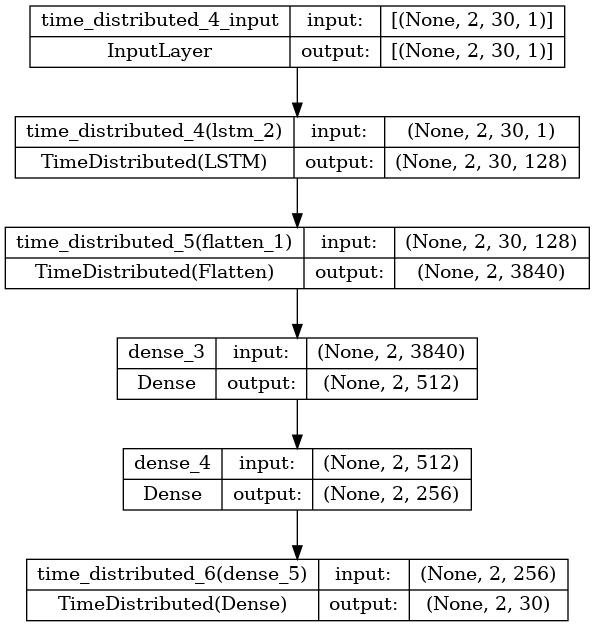

In [29]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
plot_model(model, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=True,
           show_layer_activations=False, expand_nested=True)

#### Model Fitting

In [30]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc")

Epoch 1/15
 355/3000 [==>...........................] - ETA: 1:10 - loss: 0.0182

KeyboardInterrupt: 

#### Training loss, finding Threshold

In [ ]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Loss

In [ ]:
THRESHOLD = 0.45

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


In [ ]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID

#plot the threshoold vs the actual loss values
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
plt.legend()


# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
# df_normal_grp_ID1['Signal1'].plot()

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

In [ ]:
plt.plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.legend();